In [1]:
# import packages
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np

import swifter
import great_expectations as ge

In [36]:
# import datasets
train_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
train_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_out.csv', usecols=lambda x: x!= '*Unnamed*')
test_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
test_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_out.csv', usecols=lambda x: x!= '*Unnamed*')

# split to respective input datasets
train_X_nac = train_X.iloc[:, 0:4]
train_X_dac = train_X.iloc[:, 4:20]
train_X_tac = train_X.iloc[:, 20:]
test_X_nac = test_X.iloc[:, 0:4]
test_X_dac = test_X.iloc[:, 4:20]
test_X_tac = test_X.iloc[:, 20:]

# compressed output y
# transform target >=1 to 1
def normalize_output(x):
    return np.where(x.target>1, x.target/x.target, x.target)
    
# compressed y-variable
compressed_train_y = train_y.sum(axis=1).to_frame(name='target')
compressed_test_y = test_y.sum(axis=1).to_frame(name='target')
compressed_train_y.target = compressed_train_y.swifter.apply(normalize_output, axis=1)
compressed_test_y.target = compressed_test_y.swifter.apply(normalize_output, axis=1)

# Code below perform Feature Selection with Recursive Feature Elimination (RFE)

### start with 30 features selected via RFE

In [7]:
# Get an estimator object
rfc1 = RandomForestClassifier(n_estimators = 20)
rfe = RFE(estimator = rfc1, n_features_to_select = 30, step = 1)

# train RFE model
rfe.fit(train_X,compressed_train_y)

RFE(estimator=RandomForestClassifier(n_estimators=20), n_features_to_select=30)

In [8]:
# Create new Train and Test datasets
X_train_rfe = rfe.transform(train_X)
X_test_rfe = rfe.transform(test_X)

In [9]:
# Fit the Random Forest classifier to the new train and test with 80 features
# .values will give the values in a numpy array (shape: (n,1))
#.ravel will convert that array shape to (n, ) (i.e. flatten it)

rfc1.fit(X_train_rfe, compressed_train_y.values.ravel())

RandomForestClassifier(n_estimators=20)

In [10]:
import pickle
pickle.dump(rfc1, open('/Users/eesoonhang/Desktop/Jupyter Project/Capstone - RNAModX/predictive_model/RandomForrest_1.pkl','wb'))

In [11]:
# perform prediction
pred_y = rfc1.predict(X_test_rfe)

In [12]:
# evaluate performance
from sklearn import metrics 
print("Accuracy:",metrics.accuracy_score(compressed_test_y, pred_y)) 
print("Precision:",metrics.precision_score(compressed_test_y, pred_y)) 
print("Recall:",metrics.recall_score(compressed_test_y, pred_y))
print ("AUC:", metrics.roc_auc_score(y_true=compressed_test_y, y_score=pred_y))

# visualize confusion matrix
cnf_matrix = metrics.confusion_matrix(compressed_test_y, pred_y)
print("Confusion matrix:")
print(cnf_matrix)

Accuracy: 0.7508333333333334
Precision: 0.7617391304347826
Recall: 0.73
AUC: 0.7508333333333334
Confusion matrix:
[[463 137]
 [162 438]]


In [13]:
# Get the ranking of the features. Ranking 1 for selected features
ranking = rfe.ranking_
ranking

array([ 1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  9,  1,  2,  1,  1,  1,
        1,  1,  1,  1, 12,  1, 20, 33, 42,  3, 26, 23, 35,  1, 34,  1, 47,
       32,  1, 17, 25, 14, 24, 40, 11, 13, 38,  1, 49, 54, 55, 44,  1, 29,
        6,  1,  1,  1, 36, 46, 41, 53, 51,  7, 10,  4, 28, 48, 52, 19, 39,
       15, 50,  1, 31, 22, 43, 45, 21, 27, 37, 30, 18,  8,  1, 16,  1])

In [14]:
# Get the feature importance
importance = rfc1.feature_importances_
importance

array([0.03125324, 0.03492722, 0.02906496, 0.03450938, 0.03001988,
       0.02972007, 0.04157529, 0.0289764 , 0.04003057, 0.0528212 ,
       0.03230712, 0.03249678, 0.02976695, 0.03764347, 0.02852939,
       0.03063384, 0.03189013, 0.02959706, 0.03309485, 0.02892572,
       0.02942857, 0.04005861, 0.03810063, 0.02767237, 0.03797165,
       0.03116039, 0.02853849, 0.04092211, 0.02784661, 0.03051705])

In [18]:
# convert the ranking and importance into dataframe
rfe_selected = pd.DataFrame()
rfe_selected = pd.concat([pd.DataFrame(train_X.columns), 
                          pd.DataFrame(ranking),
                          pd.DataFrame(importance)], axis=1)
rfe_selected.columns = ['Feature Name', 'Ranking', 'Importance']
rfe_selected

,Feature Name,Ranking,Importance
0,A,1,0.031253
1,C,1,0.034927
2,G,1,0.029065
3,T,1,0.034509
4,AA,1,0.030020
...,...,...,...
79,TGT,18,NaN
80,TTA,8,NaN
81,TTC,1,NaN
82,TTG,16,NaN


In [19]:
# display RFE selected features (where ranking=1)   
rfe_selected[(rfe_selected.Ranking == 1)]['Feature Name']

0       A
1       C
2       G
3       T
4      AA
5      AC
7      AT
8      CA
9      CC
10     CG
12     GA
14     GG
15     GT
16     TA
17     TC
18     TG
19     TT
20    AAA
22    AAG
30    AGG
32    ATA
35    ATT
44    CGA
49    CTC
52    GAA
53    GAC
54    GAG
70    TAG
81    TTC
83    TTT
Name: Feature Name, dtype: object

# Code below find the optimum number of feature selection
### use wrapper method: RFE
### selected n_features: based on 10, 20, 30, 40 and 50th percentile of total features

In [2]:
# import datasets
train_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
train_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_out.csv', usecols=lambda x: x!= '*Unnamed*')
test_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
test_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_out.csv', usecols=lambda x: x!= '*Unnamed*')

# compressed output y
# transform target >=1 to 1
def normalize_output(x):
    return np.where(x.target>1, x.target/x.target, x.target)
    
# compressed y-variable
compressed_train_y = train_y.sum(axis=1).to_frame(name='target')
compressed_test_y = test_y.sum(axis=1).to_frame(name='target')
compressed_train_y.target = compressed_train_y.swifter.apply(normalize_output, axis=1)
compressed_test_y.target = compressed_test_y.swifter.apply(normalize_output, axis=1)

In [3]:
# use stratified method to split the dataset for initial model training
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(train_X, compressed_train_y, test_size = 0.5, random_state = 1234, stratify=compressed_train_y)
X_train.shape

(152330, 84)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
import math

def optimum_RFEModel(n_features):
    
    print('Number of features to be selected: ' , n_features)
    
    print('instantiating model...')
    # instantiate model
    rfc = RandomForestClassifier()
    rfe = RFE(estimator = rfc, n_features_to_select = n_features, step = 1)
#     sfs = SequentialFeatureSelector(rfc, n_features_to_select=n_features, direction="backward")
    
    print('modeling RFE...')
    # apply RFE
    rfe.fit(X_train, Y_train.values.ravel())
    # refactor train_X and test_X with rfe
    print('refactoring dataset...')
    rfe_train_X = rfe.transform(X_train)
    rfe_valid_X = rfe.transform(X_valid)
    
    print('fit model...')
    # Perform RandomForestClassification
    rfc.fit(rfe_train_X, Y_train.values.ravel())
    y_predict = rfc.predict(rfe_valid_X)
    
    print('evaluate model...')
    # print ranking based on rfe
    columns = X_train.columns
    ranking = rfe.ranking_
    rfe_selected = pd.concat([pd.DataFrame(columns), 
                              pd.DataFrame(ranking)], axis=1)
    rfe_selected.columns = ['Feature Name', 'Ranking']
    print('rankings: ' + str(ranking) + '\n' + 'RFE selected features: \n' + '-'*20 + '\n' + str(rfe_selected[(rfe_selected.Ranking == 1)]['Feature Name']))

    rmse = math.sqrt(mean_squared_error(Y_valid, y_predict))
    print('rmse: %4.2f' %rmse)
    
    score = rfc.score(rfe_valid_X, Y_valid)
    print('score: %4.2f' %score)
    
    return n_features, rmse, score, rfc, rfe

In [41]:
# define a list of feature number to be selected
n_features_list = list(map(lambda x : int(x * len(train_X.columns)), [0.1, 0.2, 0.3, 0.4, 0.5]))
n_features_list

[8, 16, 25, 33, 42]

In [44]:
%time results = list(map(optimum_RFEModel, n_features_list))

8
instantiating model...
modeling SFS...
refactoring dataset...
fit model...
evaluate model...
rankings: [ 1  1  1  1 18 10 31  4 15  1  1 29  6 21  3 16  1 12  7  1  9 30 11 45
 55 61 42 51 47 58 23 56 25 70 53 13 37 50 39 52 57 33 60 54 17 75 38 76
 67 27 48 32  2 22 14 62 66 64 77 69 28 26 24 44 73 74 41 63 40 72  5 36
 46 68 71 35 49 65 59 34 19 20 43  8]
RFE selected features: 
--------------------
0      A
1      C
2      G
3      T
9     CC
10    CG
16    TA
19    TT
Name: Feature Name, dtype: object
rmse: 0.53
score: 0.72
16
instantiating model...
modeling SFS...
refactoring dataset...
fit model...
evaluate model...
rankings: [ 1  1  1  1 11  2 19  5 10  1  1 20  1 13  1  9  1  6  1  1  1 24  1 27
 44 52 36 42 38 57 14 43 16 62 50  1 29 39 28 47 45 26 51 53  3 67 25 68
 54 15 46 21  1 12  8 49 55 56 69 61 23 22 17 32 66 65 40 60 34 64  1 33
 37 58 63 31 41 59 48 30  4 18 35  7]
RFE selected features: 
--------------------
0       A
1       C
2       G
3       T
9      CC
10    

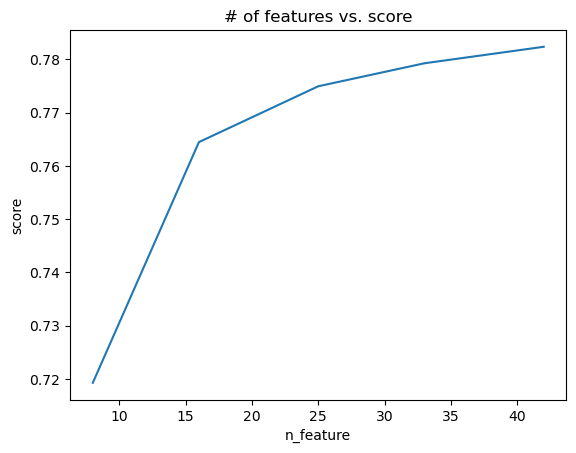

In [45]:
scores = [r[1] for r in results]

import matplotlib.pyplot as plt
plt.plot(n_features_list, scores)
plt.xlabel('n_feature')
plt.ylabel('score')
plt.title('# of features vs. score')
plt.show()

In [ ]:
# Conclusion
# The best performance obtained with rfc via rfe-treated is 0.78 accuracy (around 40th-percentile of total features)

In [22]:
# export the yet-the-best model
model = optimum_RFEModel(33)

Number of features to be selected:  33
instantiating model...
modeling RFE...
refactoring dataset...
fit model...
evaluate model...
rankings: [ 1  1  1  1  1  1  9  1  1  1  1  3  1  2  1  1  1  1  1  1  1 10  1 14
 25 38  8 31 26 36  1 30  1 46 34  1 15 27 17 24 35  6 11 37  1 49  1 51
 40  5 29 12  1  1  1 32 44 28 52 45  7  4  1 19 47 50 20 41 13 48  1  1
 23 42 39 21 22 43 33 16  1  1 18  1]
RFE selected features: 
--------------------
0       A
1       C
2       G
3       T
4      AA
5      AC
7      AT
8      CA
9      CC
10     CG
12     GA
14     GG
15     GT
16     TA
17     TC
18     TG
19     TT
20    AAA
22    AAG
30    AGG
32    ATA
35    ATT
44    CGA
46    CGG
52    GAA
53    GAC
54    GAG
62    GGG
70    TAG
71    TAT
80    TTA
81    TTC
83    TTT
Name: Feature Name, dtype: object
rmse: 0.45
score: 0.80


In [23]:
# export the model
import pickle 
pickle.dump(model[3], open('/Users/eesoonhang/Desktop/capstone_data/RFC_100trees_withRFE.pkl', 'wb'))
pickle.dump(model[4], open('/Users/eesoonhang/Desktop/capstone_data/RFE_33.pkl', 'wb'))

In [24]:
clf = model[3]
rfe = model[4]
rfe_test_X = rfe.transform(test_X)
clf.score(rfe_test_X, compressed_test_y)

0.7583333333333333

Text(0.5, 427.9555555555555, 'Predicted label')

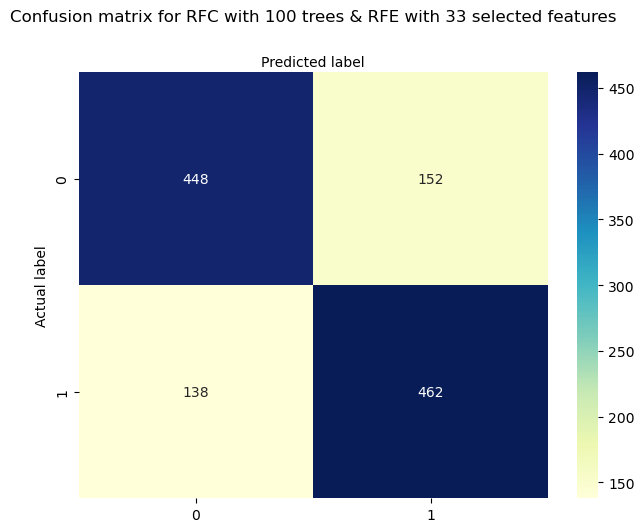

In [28]:
from sklearn.metrics import confusion_matrix as cfm
import matplotlib.pyplot as plt
import seaborn as sns
# visualize confusion matrix
cnf_matrix = cfm(compressed_test_y, clf.predict(rfe_test_X)) 
class_names=[0,1] # name  of classes
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix for RFC with 100 trees & RFE with 33 selected features', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')